In [1]:
# Familiar imports
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 500
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [4]:
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv")
test = pd.read_csv("../input/30-days-of-ml/test.csv")
submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# Preview the data
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [5]:
train['lgb_pred'] = np.load("../input/30d-lgb-pred/4lgb_oof.npy")+ np.load("../input/30d-lgb-pred/5lgb_oof.npy")
test['lgb_pred'] = np.load("../input/30d-lgb-pred/4lgb_pred.npy")+ np.load("../input/30d-lgb-pred/5lgb_pred.npy")

train['xgb_pred'] = np.load("../input/30d-ml-2021-xgb/xgb_oof.npy")
test['xgb_pred'] = np.load("../input/30d-ml-2021-xgb/xgb_pred.npy")

train['lgb2_pred'] = np.load("../input/30d-ml-2021-lgb-model-2/lgb_oof.npy")
test['lgb2_pred'] = np.load("../input/30d-ml-2021-lgb-model-2/lgb_pred.npy")

train['xgb2_pred'] = np.load("../input/30d-ml-2021-xgb-model-2/xgb_oof.npy")
test['xgb2_pred'] = np.load("../input/30d-ml-2021-xgb-model-2/xgb_pred.npy")

train['ctb2_pred'] = np.load("../input/30d-ml-2021-catb-model-2/ctb_oof.npy")
test['ctb2_pred'] = np.load("../input/30d-ml-2021-catb-model-2/ctb_pred.npy")

train['lgb_p2_pred'] = np.load("../input/30d-ml-2021-lgb-pseudo2/lgb_oof.npy")
test['lgb_p2_pred'] = np.load("../input/30d-ml-2021-lgb-pseudo2/lgb_pred.npy")

train['xgb_p2_pred'] = np.load("../input/30d-ml-2021-xgb-pseudo2/xgb_oof.npy")
test['xgb_p2_pred'] = np.load("../input/30d-ml-2021-xgb-pseudo2/xgb_pred.npy")

train['lgb2_p2_pred'] = np.load("../input/30d-ml-2021-lgb-model-2-pseudo2/lgb_oof.npy")
test['lgb2_p2_pred'] = np.load("../input/30d-ml-2021-lgb-model-2-pseudo2/lgb_pred.npy")

train['xgb2_p2_pred'] = np.load("../input/30d-ml-2021-xgb-model-2-pseudo-2/xgb_oof.npy")
test['xgb2_p2_pred'] = np.load("../input/30d-ml-2021-xgb-model-2-pseudo-2/xgb_pred.npy")

train['ctb2_p2_pred'] = np.load("../input/30d-ml-2021-catb-model-2-pseudo2/ctb_oof.npy")
test['ctb2_p2_pred'] = np.load("../input/30d-ml-2021-catb-model-2-pseudo2/ctb_pred.npy")

In [6]:
# Separate target from features
y = train['target']
features = train.drop(['id','target'], axis=1)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,lgb_pred,xgb_pred,lgb2_pred,xgb2_pred,ctb2_pred,lgb_p2_pred,xgb_p2_pred,lgb2_p2_pred,xgb2_p2_pred,ctb2_p2_pred
0,B,B,B,C,B,B,A,E,C,N,...,8.412190,8.406845,8.429377,8.463968,8.422910,8.447788,8.409527,8.424738,8.453580,8.462934
1,B,B,A,A,B,D,A,F,A,O,...,8.362972,8.342352,8.298047,8.321292,8.315539,8.356257,8.358488,8.330516,8.345897,8.336991
2,A,A,A,C,B,D,A,D,A,F,...,8.214132,8.204342,8.222232,8.199663,8.207955,8.225424,8.228208,8.233979,8.237179,8.222193
3,B,B,A,C,B,D,A,E,C,K,...,8.385730,8.386736,8.393528,8.400892,8.363494,8.384510,8.419605,8.409301,8.404530,8.371811
4,A,A,A,C,B,D,A,E,A,N,...,8.205836,8.197277,8.206230,8.210944,8.227323,8.223536,8.206048,8.236329,8.230536,8.280970


# Preprocessing

In [7]:

# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# ordinal-encode categorical columns
X = features.copy()
X_test = test.drop(['id'], axis=1).copy()
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

# Preview the ordinal-encoded features
X.head()


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,lgb_pred,xgb_pred,lgb2_pred,xgb2_pred,ctb2_pred,lgb_p2_pred,xgb_p2_pred,lgb2_p2_pred,xgb2_p2_pred,ctb2_p2_pred
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,...,8.412190,8.406845,8.429377,8.463968,8.422910,8.447788,8.409527,8.424738,8.453580,8.462934
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,...,8.362972,8.342352,8.298047,8.321292,8.315539,8.356257,8.358488,8.330516,8.345897,8.336991
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,...,8.214132,8.204342,8.222232,8.199663,8.207955,8.225424,8.228208,8.233979,8.237179,8.222193
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,...,8.385730,8.386736,8.393528,8.400892,8.363494,8.384510,8.419605,8.409301,8.404530,8.371811
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,...,8.205836,8.197277,8.206230,8.210944,8.227323,8.223536,8.206048,8.236329,8.230536,8.280970


In [8]:
'''
# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# one-hot-encode categorical columns
X = features.copy()
X_test = test.drop(['id'], axis=1).copy()

oh_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_ohe = oh_encoder.fit_transform(features[object_cols])
X_test_ohe = oh_encoder.transform(test[object_cols])

X_ohe = pd.DataFrame(X_ohe, columns=[f"ohe_{i}" for i in range(X_ohe.shape[1])])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])

X = pd.concat([X, X_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)
X = X.drop(object_cols, axis=1)
X_test = X_test.drop(object_cols, axis=1)
    
# Preview the one-hot-encoded features
X.head()
'''

'\n# List of categorical columns\nobject_cols = [col for col in features.columns if \'cat\' in col]\n\n# one-hot-encode categorical columns\nX = features.copy()\nX_test = test.drop([\'id\'], axis=1).copy()\n\noh_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")\nX_ohe = oh_encoder.fit_transform(features[object_cols])\nX_test_ohe = oh_encoder.transform(test[object_cols])\n\nX_ohe = pd.DataFrame(X_ohe, columns=[f"ohe_{i}" for i in range(X_ohe.shape[1])])\nX_test_ohe = pd.DataFrame(X_test_ohe, columns=[f"ohe_{i}" for i in range(X_test_ohe.shape[1])])\n\nX = pd.concat([X, X_ohe], axis=1)\nX_test = pd.concat([X_test, X_test_ohe], axis=1)\nX = X.drop(object_cols, axis=1)\nX_test = X_test.drop(object_cols, axis=1)\n    \n# Preview the one-hot-encoded features\nX.head()\n'

In [9]:
scale_features = [col for col in features.columns if 'pred' in col]

ss = StandardScaler()
X[scale_features] = ss.fit_transform(features[scale_features])
X_test[scale_features] = ss.transform(test[scale_features])

In [10]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Pseudo Label

In [11]:
pseudo = pd.read_csv("../input/competition-day-6-stacking10/submission.csv")[target]
train_pseudo = pd.concat([X, y], axis=1)
test_pseudo = pd.concat([X_test, pseudo], axis=1)
all_pseudo = pd.concat([train_pseudo, test_pseudo]).reset_index(drop=True)

# RF

In [12]:
rr_params = {
     'n_estimators':N_ESTIMATORS,
                    #'objective': 'regression',
              'criterion':'mse',
                  #'metric':'rmse',
              'n_jobs':-1,
              'bootstrap':True,
    
            'max_depth': 6,
             'max_features': 0.5228583626675448,
             'max_samples': 0.8642975166335827,
             'ccp_alpha': 8.850117341313198e-06
        
}

In [13]:
rr_oof = np.zeros(train.shape[0])
rr_pred = np.zeros(test.shape[0])
rr_importances = pd.DataFrame()

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[scale_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    if fold in [7,8,9]:
    
        oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
        preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])

        X_train, y_train = all_pseudo[scale_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
        #X_train = apply_noise_row(X_train)

        X_valid, y_valid = all_pseudo[scale_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
        X_test = all_pseudo[scale_features].iloc[preds_idx]

        # rr
        start = time.time()

        for inseed in seed_list:
            rr_params['random_state'] = inseed

            model = RandomForestRegressor(**rr_params, verbose=0)
            model.fit(
                X_train, 
                y_train,
                
            )

           

            with open(f"rr_model{fold}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = scale_features
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            rr_importances = rr_importances.append(fi_tmp)

            rr_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
            rr_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)

        elapsed = time.time() - start
        rmse = mean_squared_error(y_valid, rr_oof[oof_idx], squared=False)
        print(f"fold {fold} - rr rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

        
print(f"oof rr_rmse = {mean_squared_error(train[target], rr_oof, squared=False)}")

np.save("rr_oof.npy", rr_oof)
np.save("rr_pred.npy", rr_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
===== fold 5 =====
===== fold 6 =====
===== fold 7 =====
fold 7 - rr rmse: 0.713237, elapsed time: 960.12sec

===== fold 8 =====
fold 8 - rr rmse: 0.714513, elapsed time: 939.04sec

===== fold 9 =====
fold 9 - rr rmse: 0.717035, elapsed time: 960.43sec

oof rr_rmse = 6.936184077341105


# OOF predictions

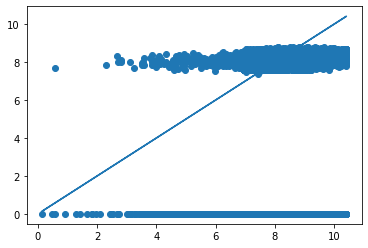

In [14]:
plt.plot(train[target], train[target])
plt.scatter(train[target], rr_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

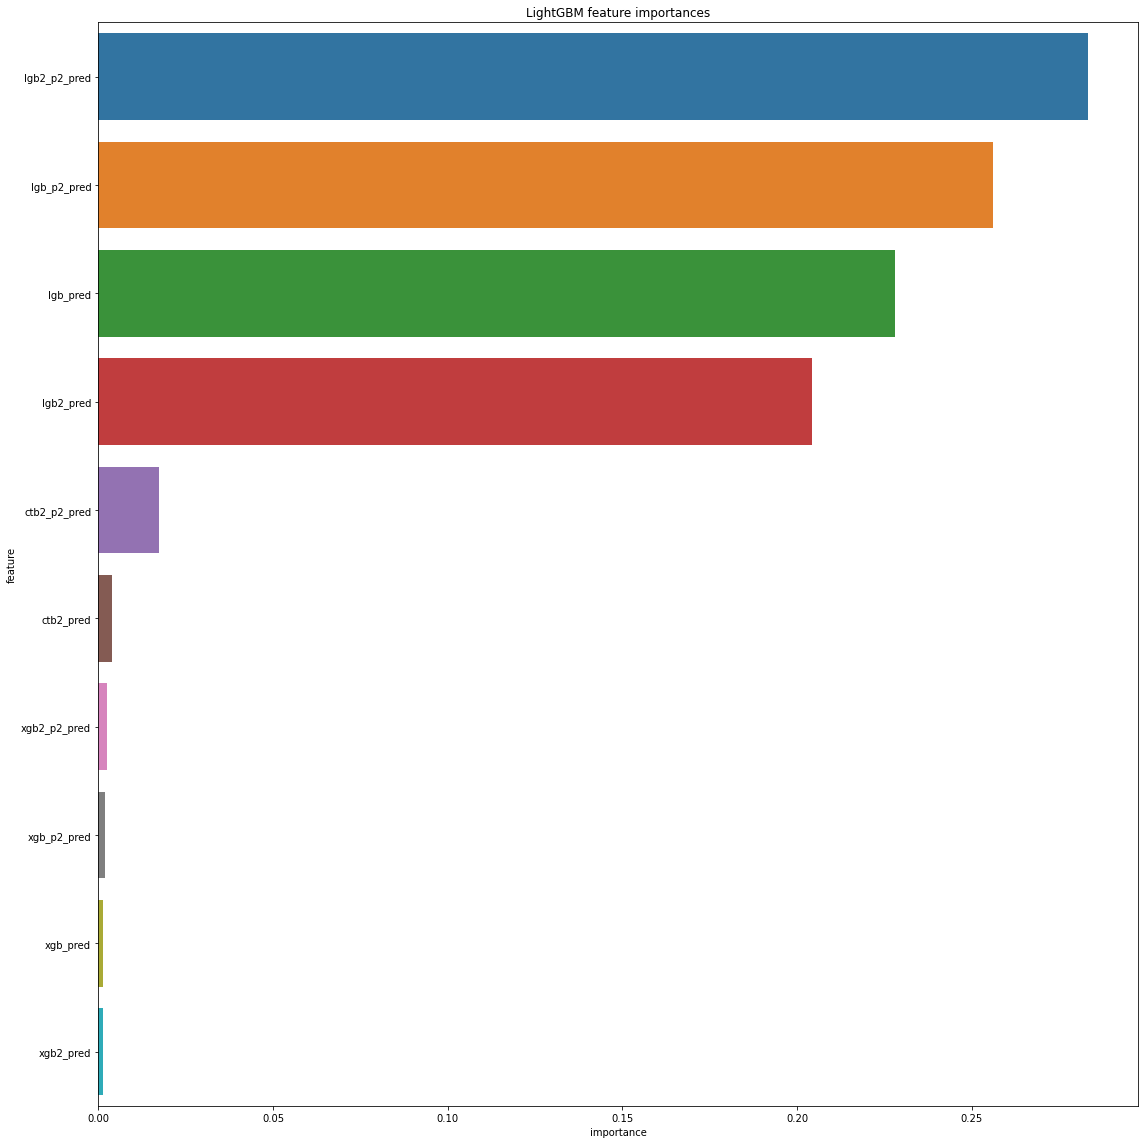

In [15]:
order = list(rr_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=rr_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [16]:
submission[target] = rr_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,0,0.000000
1,5,8.421267
2,15,0.000000
3,16,8.492365
4,17,0.000000
...,...,...
199995,499987,8.022262
199996,499990,8.488556
199997,499991,0.000000
199998,499994,0.000000
